In [0]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


In [0]:
time=np.arange(4*365+1)

In [0]:
def trend(time,slope=0.2):
  return(slope*time)

def seasonality(tm):
  return(np.where(tm<0.4,np.cos(2*np.pi*tm),1/np.exp(4*tm)))

def season_time(time,amplitude=40,period=365):
  tm=(time%period)/period
  return(amplitude*seasonality(tm))

def white_noise(time,seed=42,distortion=7):
  rnd=np.random.RandomState(seed)
  return(distortion*rnd.randn(len(time)))

In [0]:
def plotter(series,time):
  plt.figure(figsize=(10,6))
  plt.plot(time[:],series[:])
  plt.xlabel("Time")
  plt.ylabel("Trend")

In [0]:
series=10+trend(time)+season_time(time)+white_noise(time)

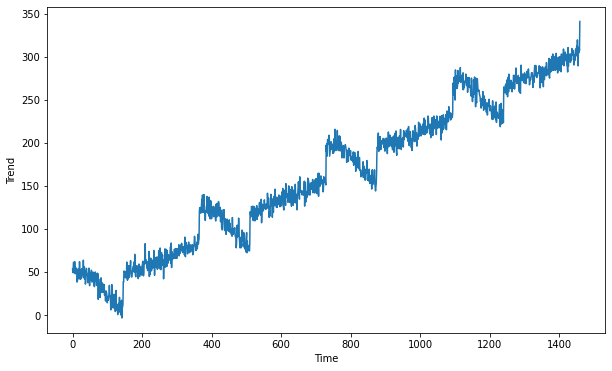

In [0]:
plotter(series,time)

In [0]:
TRAIN_SPLIT=1000
train=series[:TRAIN_SPLIT]
time_train=time[:TRAIN_SPLIT]
time_val=time[TRAIN_SPLIT:]
val=series[TRAIN_SPLIT:]

In [0]:
def window_test(series, window_size=20, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def forecast(series,model,window_size):
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda window:window.batch(window_size))
  ds=ds.batch(32).prefetch(1)
  prediction=model.predict(ds)
  return(prediction)

In [0]:
train_data=window_test(train)
valid_set=window_test(val)

In [0]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model2.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model2.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
model2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model2.fit(train_data, epochs=100,validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 18ms/step - loss: 111.3940 - mae: 111.8936 - val_loss: 238.0264 - val_mae: 238.5264
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 89.1224 - mae: 89.6219 - val_loss: 132.4389 - val_mae: 132.9389
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 40.1356 - mae: 40.6316 - val_loss: 67.2521 - val_mae: 67.7492
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 23.9821 - mae: 24.4728 - val_loss: 38.4239 - val_mae: 38.9168
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 15.8489 - mae: 16.3363 - val_loss: 22.9991 - val_mae: 23.4882
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 11.0586 - mae: 11.5440 - val_loss: 16.3877 - val_mae: 16.8734
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 9.4632 - mae: 9.9481 - val_loss: 13.3227 - val_mae: 13.8086
Epoch 8/100
31/31 [==============================]

In [0]:
cnn_forecast = forecast(series[..., np.newaxis],model2, 20)
cnn_forecast = cnn_forecast[TRAIN_SPLIT -20:-1, -1, 0]

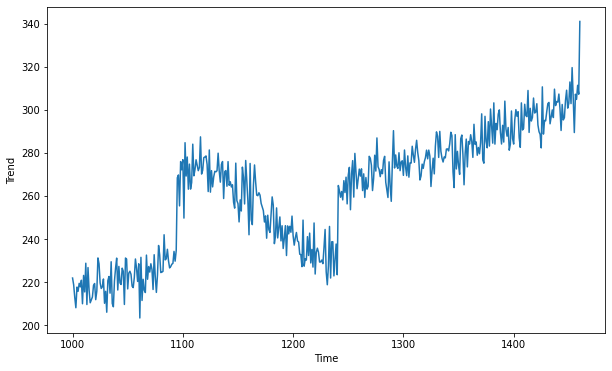

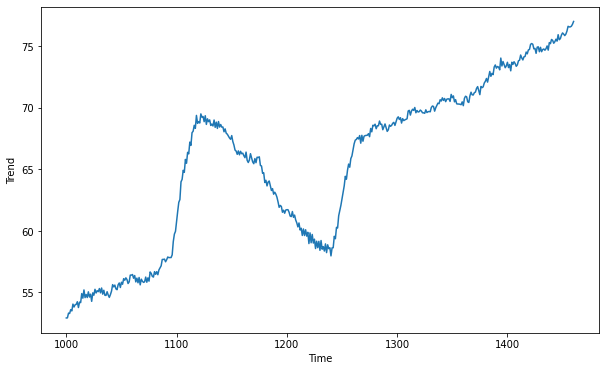

In [0]:
plotter(val,time[TRAIN_SPLIT:])
plotter(cnn_forecast,time[TRAIN_SPLIT:])

In [0]:
tf.keras.metrics.mae(val,cnn_forecast)